# Case Analysis — Function Naming Outputs

Inspect what the model *actually* predicted: raw outputs, all top-k candidates, 
cross-opt-level tracking per function, and per-test-case result tables.

**Sections:**
1. **Data Loading** — pull scored results from the API
2. **Per Test-Case Results** — every function in each test case, with predictions and scores
3. **Cross-O-Level Tracker** — same function across O0→O3, does the name change?
4. **Top-K Candidate Inspector** — all 3 candidates, which was best?
5. **Interesting Cases** — exact matches, total failures, top-k rescues
6. **Function Detail Viewer** — deep-dive into a single function

## §1 — Data Loading

In [1]:
import sys, json, warnings
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from IPython.display import display, HTML, Markdown

import requests

warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.max_rows', 200)

REFORGE_ROOT = Path(".").resolve().parent
API = "http://localhost:8080"

MODEL_LABELS = {
    "openai/gpt-4o-mini": "GPT-4o-mini",
    "deepseek/deepseek-coder-v2-0724": "DeepSeek-Coder-v2",
    "openai/gpt-5.1": "GPT-5.1",
}

def api_get(path):
    return requests.get(f"{API}{path}").json()

print(f"API: {api_get('/health')}")

API: {'status': 'healthy', 'service': 'reforge-api', 'version': '0.1.0'}


In [2]:
## Load all benchmark scored results into a single DataFrame

all_exps = api_get("/data/experiments")
benchmark_exps = [e for e in all_exps if 'benchmark-v2' in e.get('tags', [])]
print(f"Benchmark experiments: {len(benchmark_exps)}")

rows = []
for e in benchmark_exps:
    exp_id = e['id']
    try:
        scored = api_get(f"/results/{exp_id}/scores")
        exp_rows = scored.get('rows', []) if isinstance(scored, dict) else scored
        for r in exp_rows:
            meta = r.get('metadata', {}) or {}
            # Extract all candidate predictions
            predictions = meta.get('predictions', [])
            candidate_names = [p.get('name', '') for p in predictions]
            candidate_confs = [p.get('confidence', 0) for p in predictions]

            rows.append({
                'experiment_id': exp_id,
                'model': e.get('model', ''),
                'model_label': MODEL_LABELS.get(e.get('model', ''), e.get('model', '')),
                'tier': e.get('tier', ''),
                'opt': e.get('opt', ''),
                'test_case': r.get('test_case', ''),
                'ground_truth': r.get('ground_truth_name', ''),
                'predicted_name': r.get('predicted_name', ''),
                'token_f1': r.get('token_f1'),
                'exact_match': r.get('exact_match_norm'),
                'token_f1_topk': r.get('token_f1_topk'),
                'exact_match_topk': r.get('exact_match_topk'),
                'best_candidate_index': r.get('best_candidate_index'),
                'topk_uplift': r.get('topk_uplift'),
                'parse_ok': r.get('parse_ok', meta.get('parse_ok')),
                'stable_key': meta.get('stable_key', ''),
                'candidate_1': candidate_names[0] if len(candidate_names) > 0 else '',
                'candidate_2': candidate_names[1] if len(candidate_names) > 1 else '',
                'candidate_3': candidate_names[2] if len(candidate_names) > 2 else '',
                'conf_1': candidate_confs[0] if len(candidate_confs) > 0 else None,
                'conf_2': candidate_confs[1] if len(candidate_confs) > 1 else None,
                'conf_3': candidate_confs[2] if len(candidate_confs) > 2 else None,
                'response_text': r.get('response_text', ''),
            })
    except Exception as exc:
        print(f"  SKIP {exp_id}: {exc}")

df = pd.DataFrame(rows)

# Derive function_name from the last element of stable_key
df['function_name'] = df['stable_key'].str.rsplit('|', n=1).str[-1]

print(f"\nLoaded {len(df):,} scored rows from {df['experiment_id'].nunique()} experiments")
print(f"Models : {sorted(df['model_label'].unique().tolist())}")
print(f"Tiers  : {sorted(df['tier'].unique().tolist())}")
print(f"Opts   : {sorted(df['opt'].unique().tolist())}")
print(f"Test cases   : {df['test_case'].nunique()}")
print(f"Stable keys  : {df['stable_key'].nunique()} unique functions")
print(f"Parse failures: {(~df['parse_ok'].fillna(True)).sum()} / {len(df)}")

Benchmark experiments: 36

Loaded 2,076 scored rows from 33 experiments
Models : ['GPT-4o-mini', 'GPT-5.1', 'deepseek/deepseek-chat-v3-0324']
Tiers  : ['BRONZE', 'GOLD', 'SILVER']
Opts   : ['O0', 'O1', 'O2', 'O3']
Test cases   : 15
Stable keys  : 257 unique functions
Parse failures: 0 / 2076


## §2 — Per Test-Case Results

For each test case, show every function the model was asked to name, what it predicted, 
and how that compares to ground truth. This gives a full picture of model behaviour per program.

In [3]:
# Per test-case breakdown — show all predictions grouped by test case and opt level
# Focus on the gold tier (best GT confidence) for clarity

tier_filter = 'gold'  # Change to 'silver' or 'bronze' as needed
case_df = df[df['tier'].str.lower() == tier_filter].copy()

test_cases = sorted(case_df['test_case'].unique())
print(f"Test cases in {tier_filter.upper()} tier: {len(test_cases)}\n")

for tc in test_cases:
    tc_data = case_df[case_df['test_case'] == tc].sort_values(['opt', 'ground_truth'])
    
    display(Markdown(f"### `{tc}` — {tier_filter.upper()} tier ({len(tc_data)} rows)"))
    
    show_cols = ['opt', 'ground_truth', 'predicted_name', 'token_f1', 'exact_match',
                 'candidate_2', 'candidate_3', 'token_f1_topk', 'topk_uplift']
    
    styled = (tc_data[show_cols]
              .style
              .format({'token_f1': '{:.3f}', 'token_f1_topk': '{:.3f}', 
                       'topk_uplift': '{:+.3f}'}, na_rep='—')
              .map(lambda v: 'background-color: #c6efce; color: #1a1a1a' if v == True else 
                       ('background-color: #ffc7ce; color: #1a1a1a' if v == False else ''),
                       subset=['exact_match']))
    display(styled)
    print()

Test cases in GOLD tier: 15



### `t01_crossfile_calls` — GOLD tier (88 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
162,O0,array_max,find_maximum_value,0.000,False,get_largest_integer,retrieve_max_element,0.400,+0.400
783,O0,array_max,find_max_value,0.400,False,get_array_max,compare_values,0.800,+0.400
1544,O0,array_max,array_max_value,0.800,False,find_array_max,max_of_ints,0.800,+0.000
139,O0,array_min,find_minimum_value,0.000,False,get_minimum_from_array,minimum_value_in_range,0.333,+0.333
844,O0,array_min,find_min_value,0.400,False,array_min,get_smallest_element,1.000,+0.600
1531,O0,array_min,int_array_min,0.800,False,find_min_element,get_min_int,0.800,+0.000
4,O0,array_print,print_integer_array,0.800,False,format_integer_list,output_array_with_brackets,0.800,+0.000
867,O0,array_print,print_int_array,0.800,False,debug_print_array,display_numbers,0.800,+0.000
1569,O0,array_print,print_int_array,0.800,False,print_uint_array,debug_print_array,0.800,+0.000
151,O0,array_sum,sum_array_elements,0.800,False,calculate_sum,aggregate_integers,0.800,+0.000


### `t02_shared_header_macros` — GOLD tier (29 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
187,O0,bubble_sort,bubble_sort,1.000,True,sort_array,perform_sort,1.000,+0.000
869,O0,bubble_sort,sort_integers,0.500,False,bubble_sort,swap_elements,1.000,+0.500
1384,O0,bubble_sort,bubble_sort_int_array,0.667,False,sort_int_array_ascending,bubble_sort_buffer,0.800,+0.133
113,O0,gcd,calculate_gcd,0.667,False,absolute_value_gcd,gcd_with_negatives,0.667,+0.000
791,O0,gcd,compute_gcd,0.667,False,absolute_difference,math_operation,0.667,+0.000
1497,O0,gcd,greatest_common_divisor,0.000,False,compute_gcd,int_gcd,0.667,+0.667
176,O0,insertion_sort,insertion_sort,1.000,True,sort_array,insert_element,1.000,+0.000
854,O0,insertion_sort,sort_integers,0.500,False,insertion_sort,array_sort,1.000,+0.500
1559,O0,insertion_sort,insertion_sort_int_array,0.667,False,insertion_sort_ints,sort_int_array_inplace,0.800,+0.133
99,O0,lcm,calculate_product,0.000,False,process_parameters,invoke_helper_functions,0.000,+0.000


### `t03_header_dominant` — GOLD tier (21 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
39,O0,linear_search,call_function_wrapper,0.000,False,invoke_helper_function,execute_subroutine,0.000,+0.000
722,O0,linear_search,wrapper_function,0.000,False,forward_function,pass_through,0.000,+0.000
1432,O0,linear_search,func_4012e1_wrapper,0.000,False,simple_call_thunk,direct_forward_stub,0.000,+0.000
0,O0,printf,print_header_footer,0.000,False,execute_header_tasks,display_process_status,0.000,+0.000
879,O0,printf,print_test_header,0.000,False,run_test_suite,main,0.000,+0.000
1398,O0,printf,run_header_dominant_test,0.000,False,t03_header_dominant_main,header_dominant_driver,0.000,+0.000
29,O0,run_search_tests,search_test_function,0.333,False,find_and_report,execute_search_tests,0.667,+0.333
708,O0,run_search_tests,test_search_algorithm,0.333,False,run_search_tests,validate_search_function,1.000,+0.667
1424,O0,run_search_tests,run_search_tests,1.000,True,search_demo_routine,search_functional_test,1.000,+0.000
12,O0,run_stack_tests,stack_test_function,0.333,False,perform_stack_operations,execute_stack_tests,0.667,+0.333


### `t04_static_dup_names` — GOLD tier (60 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
76,O0,accumulate,sum_if_condition_met,0.000,False,conditional_sum,aggregate_values,0.000,+0.000
757,O0,accumulate,sum_valid_elements,0.000,False,count_valid_values,process_array,0.000,+0.000
1469,O0,accumulate,sum_filtered_elements,0.000,False,accumulate_matching_values,sum_if_predicate,0.500,+0.500
141,O0,count_valid,count_non_zero_results,0.333,False,count_valid_entries,iterate_and_count,0.800,+0.467
817,O0,count_valid,count_matching_elements,0.400,False,validate_array_elements,process_array,0.400,+0.000
1532,O0,count_valid,count_predicate_matches,0.400,False,count_matching_elements,count_array_condition_true,0.400,+0.000
50,O0,main,print_static_dup_names,0.000,False,initialize_and_print,execute_static_name_tests,0.000,+0.000
736,O0,main,test_static_array_operations,0.000,False,demo_array_processing,run_test_sequence,0.000,+0.000
1448,O0,main,static_dup_names_demo,0.000,False,run_static_dup_names_test,test_static_dup_names_case,0.000,+0.000
55,O0,process,absolute_value_plus_one,0.000,False,negate_and_increment,calculate_adjusted_value,0.000,+0.000


### `t05_fptr_callbacks` — GOLD tier (120 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
189,O0,main,execute_dispatch_table,0.000,False,process_transform_chain,run_phase_operations,0.000,+0.000
868,O0,main,run_callback_demo,0.000,False,test_function_pointers,dispatch_transform_chain,0.000,+0.000
1386,O0,main,test_fptr_callbacks,0.000,False,run_callback_dispatch_demo,fptr_callback_phases_demo,0.000,+0.000
136,O0,op_count_positive,count_positive_integers,0.667,False,count_non_zero_elements,sum_positive_values,0.667,+0.000
819,O0,op_count_positive,count_positive_ints,0.667,False,sum_positive_elements,check_array_values,0.667,+0.000
1522,O0,op_count_positive,count_positive_ints,0.667,False,array_count_positive,count_positive_elements,0.667,+0.000
150,O0,op_max,find_maximum_value,0.000,False,get_largest_integer,retrieve_max_element,0.400,+0.400
828,O0,op_max,find_max_value,0.400,False,get_array_max,compare_values,0.400,+0.000
1533,O0,op_max,array_max_value,0.400,False,find_array_max,get_max_int,0.400,+0.000
164,O0,op_product,calculate_product,0.500,False,multiply_array_elements,array_product_calculator,0.500,+0.000


### `t06_recursion_inline` — GOLD tier (36 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
15,O0,ackermann,recursive_calculation,0.000,False,calculate_value,process_parameters,0.000,+0.000
693,O0,ackermann,compute_recursive_value,0.000,False,calculate_pair_result,recursive_math_operation,0.000,+0.000
1411,O0,ackermann,compute_ackermann,0.667,False,ackermann_function,bounded_ackermann,0.667,+0.000
65,O0,fibonacci,fibonacci_calculator,0.667,False,recursive_fibonacci,calculate_fibonacci,0.667,+0.000
744,O0,fibonacci,compute_fibonacci,0.667,False,recursive_sum,calculate_sequence,0.667,+0.000
1462,O0,fibonacci,recursive_fibonacci,0.667,False,compute_fibonacci,fibonacci_recursive_wrapper,0.667,+0.000
51,O0,gcd,recursive_modulus,0.000,False,calculate_modulus,modulus_with_reduction,0.000,+0.000
729,O0,gcd,compute_gcd,0.667,False,recursive_math_op,handle_modulo,0.667,+0.000
1447,O0,gcd,compute_gcd,0.667,False,recursive_gcd,normalized_gcd,0.667,+0.000
1,O0,main,run_recursion_tests,0.000,False,execute_math_functions,display_algorithm_results,0.000,+0.000


### `t07_switch_parser` — GOLD tier (102 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
177,O0,advance,initialize_global_vars,0.000,False,set_global_data,configure_memory,0.000,+0.000
858,O0,advance,initialize_global_data,0.000,False,copy_memory_block,update_system_state,0.000,+0.000
1572,O0,advance,init_global_digest_state,0.000,False,derive_global_key,init_160bit_global_buffer,0.000,+0.000
127,O0,evaluate_expression,set_global_data,0.000,False,initialize_globals,update_state,0.000,+0.000
806,O0,evaluate_expression,initialize_globals,0.000,False,setup_environment,start_services,0.000,+0.000
1519,O0,evaluate_expression,set_global_context_and_init,0.000,False,set_global_arg_and_init,init_runtime_with_param,0.000,+0.000
114,O0,evaluate_rpn,stack_calculator,0.000,False,operation_executor,dynamic_stack_handler,0.000,+0.000
795,O0,evaluate_rpn,execute_bytecode,0.000,False,process_instructions,evaluate_stack_operations,0.400,+0.400
1515,O0,evaluate_rpn,eval_rpn_expression,0.400,False,execute_arith_bytecode,stack_vm_evaluate,0.400,+0.000
28,O0,main,expression_evaluator,0.000,False,rpn_calculator,switch_parser,0.000,+0.000


### `t08_loop_heavy` — GOLD tier (168 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
54,O0,bubble_sort,bubble_sort,1.000,True,sort_array,perform_sort,1.000,+0.000
734,O0,bubble_sort,bubble_sort,1.000,True,sort_array,swap_elements,1.000,+0.000
1450,O0,bubble_sort,bubble_sort_int_array,0.667,False,int_array_bubble_sort,sort_ints_ascending,0.667,+0.000
43,O0,insertion_sort,insertion_sort,1.000,True,sort_array_segment,partial_array_sort,1.000,+0.000
723,O0,insertion_sort,sort_integers,0.500,False,insertion_sort,array_sort,1.000,+0.500
1437,O0,insertion_sort,insertion_sort_int_array,0.667,False,insertion_sort_ints,sort_int_array_inplace,0.800,+0.133
17,O0,is_sorted,check_sorted_array,0.400,False,validate_increasing_order,is_array_sorted,0.800,+0.400
697,O0,is_sorted,check_array_sorted,0.400,False,verify_ascending_order,is_sorted,1.000,+0.600
1413,O0,is_sorted,is_int_array_sorted_ascending,0.571,False,check_non_decreasing_int_array,validate_sorted_int_sequence,0.571,+0.000
66,O0,main,matrix_operations,0.000,False,matrix_sorting,matrix_transformation,0.000,+0.000


### `t09_string_format` — GOLD tier (93 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
79,O0,format_int_array,format_integer_array,0.667,False,serialize_integer_list,build_integer_string,0.667,+0.000
760,O0,format_int_array,format_int_array,1.000,True,serialize_numbers,print_number_list,1.000,+0.000
1474,O0,format_int_array,format_int_array,1.000,True,format_int_array_style,render_int_vector,1.000,+0.000
67,O0,format_key_value,format_string_output,0.333,False,generate_formatted_string,custom_string_formatter,0.333,+0.000
748,O0,format_key_value,format_string_pair,0.333,False,format_key_value,format_two_fields,1.000,+0.667
1463,O0,format_key_value,format_key_value_pair,0.857,False,format_kv_with_style,render_key_value_output,0.857,+0.000
104,O0,format_record,format_score_output,0.400,False,generate_score_string,create_score_representation,0.400,+0.000
788,O0,format_record,format_player_stats,0.400,False,format_entity_data,format_score_entry,0.400,+0.000
1503,O0,format_record,format_score_record,0.800,False,format_entry_string,format_id_name_score,0.800,+0.000
168,O0,level_prefix,get_data_pointer,0.000,False,retrieve_data_by_index,fetch_data_reference,0.000,+0.000


### `t10_math_libm` — GOLD tier (111 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
157,O0,deg_to_rad,calculate_ratio,0.000,False,scale_value,compute_scaled_value,0.000,+0.000
835,O0,deg_to_rad,convert_units,0.000,False,scale_value,apply_factor,0.000,+0.000
1537,O0,deg_to_rad,scale_value,0.000,False,normalize_value,convert_units,0.000,+0.000
45,O0,geometric_mean,calculate_geometric_mean,0.800,False,logarithmic_average,average_log_exp,0.800,+0.000
724,O0,geometric_mean,compute_geometric_mean,0.800,False,calculate_log_average,process_double_array,0.800,+0.000
1427,O0,geometric_mean,compute_geometric_mean,0.800,False,array_geometric_mean,geometric_mean_or_default,0.800,+0.000
18,O0,main,math_library_demo,0.000,False,trigonometry_and_stats,angle_normalization_demo,0.000,+0.000
698,O0,main,demo_math_operations,0.000,False,test_math_functions,show_math_examples,0.000,+0.000
1405,O0,main,math_libm_demo_main,0.400,False,math_libm_trig_stats_demo,math_libm_test_harness,0.400,+0.000
92,O0,mean,calculate_average,0.000,False,average_from_array,mean_of_doubles,0.500,+0.500


### `t11_mixed_stress` — GOLD tier (168 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
181,O0,engine_count,get_global_value,0.000,False,retrieve_static_data,fetch_constant,0.000,+0.000
861,O0,engine_count,get_global_value,0.000,False,read_config_value,get_static_data,0.000,+0.000
1564,O0,engine_count,get_global_value,0.000,False,get_config_flag,get_static_uint32,0.000,+0.000
7,O0,engine_init,initialize_memory,0.000,False,reset_data_structure,clear_buffer,0.000,+0.000
880,O0,engine_init,initialize_memory,0.000,False,clear_buffer,reset_state,0.000,+0.000
1402,O0,engine_init,reset_global_state,0.000,False,init_global_buffer,clear_buffer_state,0.400,+0.400
191,O0,engine_register,store_data_entry,0.000,False,add_entry_to_list,increment_and_store,0.000,+0.000
874,O0,engine_register,push_queue_item,0.000,False,add_to_buffer,store_data_record,0.000,+0.000
1389,O0,engine_register,append_global_record,0.000,False,add_record_to_table,register_quadword_entry,0.400,+0.400
170,O0,engine_run_all,initialize_plugins,0.000,False,run_plugin_tests,load_and_execute_plugins,0.333,+0.333


### `t12_state_machine` — GOLD tier (234 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
135,O0,auth_enter,log_auth_verification,0.400,False,print_auth_status,output_auth_message,0.400,+0.000
812,O0,auth_enter,verify_credentials,0.000,False,auth_check,print_auth_status,0.500,+0.500
1529,O0,auth_enter,log_auth_verifying_credentials,0.333,False,print_auth_verification_message,auth_verification_status_log,0.333,+0.000
121,O0,auth_exit,do_nothing_function,0.000,False,empty_function,no_operation,0.000,+0.000
802,O0,auth_exit,do_nothing,0.000,False,empty_function,placeholder_function,0.000,+0.000
1518,O0,auth_exit,noop_function,0.000,False,empty_stub,do_nothing,0.000,+0.000
109,O0,auth_handle,handle_authentication,0.500,False,process_auth_status,set_auth_error_message,0.500,+0.000
864,O0,auth_handle,handle_auth_error,0.800,False,process_status_code,dispatch_error_message,0.800,+0.000
1506,O0,auth_handle,handle_auth_status_code,0.667,False,update_auth_result,map_auth_error_code,0.667,+0.000
123,O0,conn_enter,log_connection_attempt,0.000,False,print_connection_attempt,report_connection_attempt,0.000,+0.000


### `t13_goto_labels` — GOLD tier (48 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
192,O0,acquire_resources,allocate_resources,0.500,False,initialize_memory,setup_resource_array,0.500,+0.000
706,O0,acquire_resources,allocate_resources,0.500,False,init_resource_pool,setup_resource_blocks,0.500,+0.000
1498,O0,acquire_resources,allocate_resource_slots,0.000,False,init_resource_descriptors,setup_resource_pool,0.000,+0.000
13,O0,log_action,log_interpreter_state,0.400,False,print_interpreter_info,output_debug_message,0.400,+0.000
122,O0,log_action,log_resource_info,0.400,False,print_resource_details,output_resource_message,0.400,+0.000
866,O0,log_action,log_interpreter_state,0.400,False,print_pc_message,debug_log,0.500,+0.100
887,O0,log_action,log_resource,0.500,False,print_resource_info,display_resource,0.500,+0.000
1394,O0,log_action,log_interp_pc,0.400,False,print_interp_trace,debug_interp_step,0.400,+0.000
1556,O0,log_action,log_resource_message,0.400,False,print_resource_info,debug_resource_log,0.400,+0.000
3,O0,main,test_pipeline_processing,0.000,False,resource_management_tests,multi_stage_initialization,0.000,+0.000


### `t14_anon_aggregates` — GOLD tier (96 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
161,O0,check_port_range,check_short_value,0.333,False,validate_short_param,short_param_status,0.333,+0.000
813,O0,check_port_range,is_valid_input,0.000,False,check_short_value,validate_param,0.333,+0.333
1396,O0,check_port_range,is_valid_short,0.000,False,is_non_zero_or_minus_one,check_short_validity,0.333,+0.333
10,O0,entry_init,initialize_buffer,0.000,False,setup_memory_structure,configure_data_block,0.000,+0.000
865,O0,entry_init,init_message_header,0.400,False,setup_network_packet,configure_data_buffer,0.400,+0.000
1446,O0,entry_init,init_flagged_record,0.400,False,build_header_with_name,encode_flags_and_label,0.400,+0.000
146,O0,entry_print,log_status_info,0.000,False,print_status_report,display_status_message,0.400,+0.400
801,O0,entry_print,print_task_status,0.400,False,log_operation_state,display_status_info,0.400,+0.000
1388,O0,entry_print,print_record_status_line,0.333,False,dump_task_status,debug_print_entry_info,0.667,+0.333
48,O0,main,test_protocol_messages,0.000,False,test_entry_registry,test_shapes_nested,0.000,+0.000


### `t15_deep_nesting` — GOLD tier (108 rows)

,opt,ground_truth,predicted_name,token_f1,exact_match,candidate_2,candidate_3,token_f1_topk,topk_uplift
111,O0,deep_do_while_cascade,collatz_sequence_transform,0.000,False,iterate_collatz_steps,process_integer_array,0.000,+0.000
765,O0,deep_do_while_cascade,process_collatz_sequence,0.000,False,transform_integer_array,iterate_number_operations,0.000,+0.000
1499,O0,deep_do_while_cascade,collatz_array_transform,0.000,False,collatz_array_iterate_limited,collatz_step_counter,0.000,+0.000
49,O0,deep_goto_error_cascade,calculate_cascade_sum,0.286,False,process_integer_array,allocate_and_sum,0.286,+0.000
704,O0,deep_goto_error_cascade,calculate_weighted_sum,0.000,False,process_array_values,validate_and_transform_array,0.000,+0.000
1442,O0,deep_goto_error_cascade,cascade_compute_score,0.286,False,cascade_transform_and_sum,cascade_validate_and_sum,0.286,+0.000
125,O0,deep_if_chain,evaluate_parameters,0.000,False,compare_uints,determine_value_based_on_conditions,0.000,+0.000
717,O0,deep_if_chain,compare_and_return_status,0.000,False,validate_input_conditions,multi_param_logic_check,0.000,+0.000
1510,O0,deep_if_chain,compare_int_pairs,0.000,False,classify_four_integers,compute_quad_state_code,0.000,+0.000
195,O0,deep_loop_nest,calculate_max_weight,0.000,False,find_peak_value,evaluate_grid_sum,0.000,+0.000


## §3 — Cross-O-Level Tracker

Track the **same function** across optimization levels O0→O3 using `stable_key`.
Shows how predictions shift (or stay stable) as the compiler transforms the code.

In [6]:
# Cross-opt pivot: one row per function, columns show prediction at each O-level
# Filter to gold tier for best coverage

tier_filter = 'gold'
cross = df[df['tier'].str.lower() == tier_filter].copy()

# Build pivot: stable_key × opt → predicted_name
pred_pivot = cross.pivot_table(
    index=['stable_key', 'ground_truth', 'test_case'],
    columns='opt',
    values='predicted_name',
    aggfunc='first'
).reindex(columns=['O0', 'O1', 'O2', 'O3'])

# Build matching F1 pivot
f1_pivot = cross.pivot_table(
    index=['stable_key', 'ground_truth', 'test_case'],
    columns='opt',
    values='token_f1',
    aggfunc='first'
).reindex(columns=['O0', 'O1', 'O2', 'O3'])

# Rename columns for clarity
pred_pivot.columns = [f'pred_{c}' for c in pred_pivot.columns]
f1_pivot.columns = [f'f1_{c}' for c in f1_pivot.columns]

tracker = pd.concat([pred_pivot, f1_pivot], axis=1).reset_index()

# Count how many distinct predictions per function across O-levels
pred_cols = [c for c in tracker.columns if c.startswith('pred_')]
tracker['n_distinct_preds'] = tracker[pred_cols].apply(
    lambda row: row.dropna().nunique(), axis=1
)

# Sort: most variable functions first (most interesting)
tracker = tracker.sort_values('n_distinct_preds', ascending=False)

# Interleave pred and f1 columns for readability
display_cols = ['test_case', 'ground_truth', 'n_distinct_preds']
for opt in ['O0', 'O1', 'O2', 'O3']:
    display_cols.extend([f'pred_{opt}', f'f1_{opt}'])

print(f"Cross-O-Level tracker — {tier_filter.upper()} tier ({len(tracker)} functions)")
print(f"Functions with identical predictions at all O-levels: "
      f"{(tracker['n_distinct_preds'] == 1).sum()} / {len(tracker)}")
print(f"Functions that change across O-levels: "
      f"{(tracker['n_distinct_preds'] > 1).sum()} / {len(tracker)}")
print()

display(tracker[display_cols].style.format(
    {c: '{:.2f}' for c in display_cols if c.startswith('f1_')}, na_rep='—')
)

Cross-O-Level tracker — GOLD tier (200 functions)
Functions with identical predictions at all O-levels: 125 / 200
Functions that change across O-levels: 75 / 200



,test_case,ground_truth,n_distinct_preds,pred_O0,f1_O0,pred_O1,f1_O1,pred_O2,f1_O2,pred_O3,f1_O3
51,t06_recursion_inline,main,4,run_recursion_tests,0.00,run_math_tests,0.00,run_recursive_algorithms,0.00,print_math_operations,0.00
197,t15_deep_nesting,deep_search_grid,4,count_adjacent_matches,0.00,find_value_in_matrix,0.00,find_matching_value,0.00,count_occurrences,0.00
78,t08_loop_heavy,mat_sum,4,sum_2d_array,0.33,sum_integers_in_range,0.33,calculate_array_sum,0.40,aggregate_values,0.00
73,t08_loop_heavy,mat_fill_pattern,4,populate_array_with_values,0.00,increment_and_store,0.00,process_integer_array,0.00,populate_array,0.00
47,t05_fptr_callbacks,tx_clamp,3,clamp_values,0.50,clamp_values,0.50,set_values_based_on_condition,0.00,set_array_values,0.00
45,t05_fptr_callbacks,tx_double,3,double_array_elements,0.40,bitwise_left_shift,0.00,bitwise_shift_array,0.00,bitwise_shift_array,0.00
49,t05_fptr_callbacks,main,3,execute_dispatch_table,0.00,execute_dispatch_phases,0.00,execute_dispatch_process,0.00,execute_dispatch_phases,0.00
65,t07_switch_parser,next_token,3,parse_input_expression,0.00,parse_format_specifiers,0.00,parse_format_specifier,0.00,parse_format_specifier,0.00
75,t08_loop_heavy,mat_transpose,3,swap_2d_array_elements,0.00,swap_memory_blocks,0.00,swap_memory_blocks,0.00,swap_array_elements,0.00
129,t11_mixed_stress,plug_c_run,3,count_non_negative_integers,0.00,count_positive_negative,0.00,count_non_negative,0.00,count_positive_negative,0.00


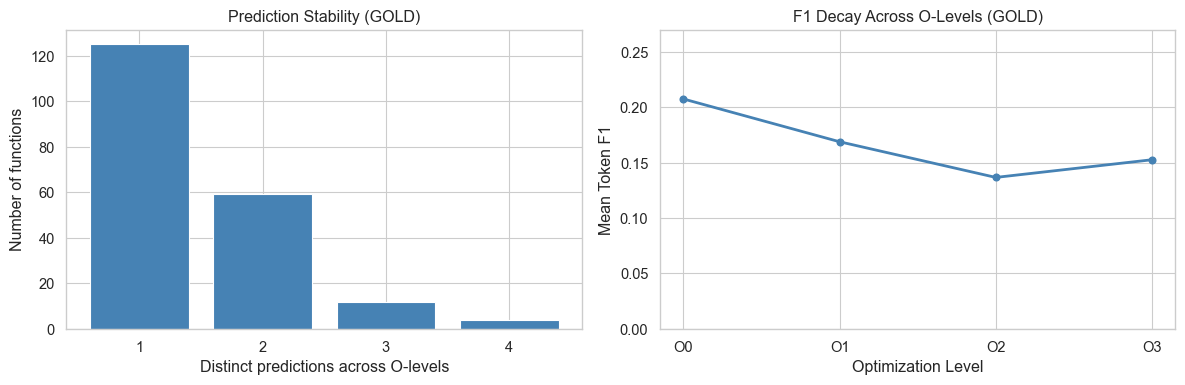

In [7]:
# Summary: prediction stability across O-levels

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of n_distinct_preds
stability_counts = tracker['n_distinct_preds'].value_counts().sort_index()
axes[0].bar(stability_counts.index, stability_counts.values, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Distinct predictions across O-levels')
axes[0].set_ylabel('Number of functions')
axes[0].set_title(f'Prediction Stability ({tier_filter.upper()})')
axes[0].set_xticks(range(1, int(stability_counts.index.max()) + 1))

# F1 decay from O0 → O3
f1_cols = [c for c in tracker.columns if c.startswith('f1_O')]
mean_f1 = tracker[f1_cols].mean()
axes[1].plot(['O0', 'O1', 'O2', 'O3'], mean_f1.values, 
             marker='o', linewidth=2, color='steelblue')
axes[1].set_xlabel('Optimization Level')
axes[1].set_ylabel('Mean Token F1')
axes[1].set_title(f'F1 Decay Across O-Levels ({tier_filter.upper()})')
axes[1].set_ylim(0, max(mean_f1.values) * 1.3 if mean_f1.values.max() > 0 else 1)

plt.tight_layout()
plt.show()

## §4 — Top-K Candidate Inspector

Show all 3 candidates the model returned, their confidence scores,
and which candidate scored best against ground truth.

In [ ]:
# Top-K candidate table: show all 3 candidates with confidence and best-candidate marker

topk_view = df[df['candidate_1'].str.len() > 0].copy()

topk_display = topk_view[[
    'test_case', 'opt', 'tier', 'ground_truth',
    'candidate_1', 'conf_1',
    'candidate_2', 'conf_2',
    'candidate_3', 'conf_3',
    'best_candidate_index', 'token_f1', 'token_f1_topk', 'topk_uplift'
]].sort_values(['test_case', 'tier', 'opt', 'ground_truth'])

# Mark which candidate was best
topk_display['best'] = topk_display['best_candidate_index'].apply(
    lambda x: f'#{int(x)+1}' if pd.notna(x) else '—'
)

print(f"Top-K candidates: {len(topk_display)} rows")
print(f"Cases where top-1 was NOT the best: "
      f"{(topk_display['best_candidate_index'] > 0).sum()} / {len(topk_display)} "
      f"({(topk_display['best_candidate_index'] > 0).mean()*100:.1f}%)")
print(f"Mean uplift when top-k helps: "
      f"{topk_display[topk_display['topk_uplift'] > 0]['topk_uplift'].mean():.3f}")
print()

# Show a compact version
show = topk_display[[
    'test_case', 'opt', 'tier', 'ground_truth',
    'candidate_1', 'candidate_2', 'candidate_3',
    'best', 'token_f1', 'token_f1_topk', 'topk_uplift'
]]

display(show.style.format(
    {'token_f1': '{:.3f}', 'token_f1_topk': '{:.3f}', 'topk_uplift': '{:+.3f}'},
    na_rep='—'
).map(
    lambda v: 'color: #2ecc71; font-weight: bold' if isinstance(v, str) and v in ('#2', '#3') else '',
    subset=['best']
))

Top-K candidates: 692 rows
Cases where top-1 was NOT the best: 102 / 692 (14.7%)
Mean uplift when top-k helps: 0.381



,test_case,opt,tier,ground_truth,candidate_1,candidate_2,candidate_3,best,token_f1,token_f1_topk,topk_uplift
637,t01_crossfile_calls,O2,BRONZE,,calculate_string_length,get_length_excluding_first_char,string_length_with_offset,#1,0.000,0.000,+0.000
662,t01_crossfile_calls,O3,BRONZE,,calculate_string_length,get_length_excluding_first_char,string_length_with_offset,#1,0.000,0.000,+0.000
162,t01_crossfile_calls,O0,GOLD,array_max,find_maximum_value,get_largest_integer,retrieve_max_element,#3,0.000,0.400,+0.400
139,t01_crossfile_calls,O0,GOLD,array_min,find_minimum_value,get_minimum_from_array,minimum_value_in_range,#2,0.000,0.333,+0.333
4,t01_crossfile_calls,O0,GOLD,array_print,print_integer_array,format_integer_list,output_array_with_brackets,#1,0.800,0.800,+0.000
151,t01_crossfile_calls,O0,GOLD,array_sum,sum_array_elements,calculate_sum,aggregate_integers,#1,0.800,0.800,+0.000
14,t01_crossfile_calls,O0,GOLD,main,print_array_statistics,display_string_operations,execute_print_commands,#1,0.000,0.000,+0.000
63,t01_crossfile_calls,O0,GOLD,string_count_char,count_character_occurrences,count_char_in_string,string_character_counter,#2,0.333,0.857,+0.524
25,t01_crossfile_calls,O0,GOLD,string_is_alpha,is_alpha_character,check_character_case,validate_character_range,#1,0.667,0.667,+0.000
75,t01_crossfile_calls,O0,GOLD,string_length,string_length,count_characters,calculate_string_size,#1,1.000,1.000,+0.000


## §5 — Interesting Cases

Automatically surface noteworthy patterns:
- **Exact matches** — model nailed it
- **Total failures** — F1 = 0 across all candidates
- **Top-K rescues** — top-1 was wrong but a lower candidate was correct/better
- **O-level collapse** — function scored well at O0 but dropped to 0 at O3

In [9]:
# === Exact Matches ===
exact = df[df['exact_match'] == True].copy()
display(Markdown(f"### Exact Matches — {len(exact)} rows"))
if len(exact) > 0:
    display(exact[['test_case', 'opt', 'tier', 'ground_truth', 'predicted_name', 'token_f1']]
            .sort_values(['test_case', 'opt'])
            .style.format({'token_f1': '{:.3f}'}, na_rep='—'))
else:
    print("None found.")

print()

# === Total Failures (F1 = 0 for all candidates) ===
failures = df[(df['token_f1'] == 0) & (df['token_f1_topk'] == 0)].copy()
display(Markdown(f"### Total Failures (F1=0 across all candidates) — {len(failures)} rows"))
if len(failures) > 0:
    display(failures[['test_case', 'opt', 'tier', 'ground_truth', 'predicted_name',
                       'candidate_2', 'candidate_3']]
            .sort_values(['test_case', 'opt'])
            .head(50))
else:
    print("None found.")

print()

# === Top-K Rescues (topk_uplift > 0) ===
rescues = df[df['topk_uplift'] > 0].copy().sort_values('topk_uplift', ascending=False)
display(Markdown(f"### Top-K Rescues (top-1 wrong, lower candidate better) — {len(rescues)} rows"))
if len(rescues) > 0:
    display(rescues[['test_case', 'opt', 'tier', 'ground_truth', 
                      'candidate_1', 'candidate_2', 'candidate_3',
                      'best_candidate_index', 'token_f1', 'token_f1_topk', 'topk_uplift']]
            .head(30)
            .style.format({'token_f1': '{:.3f}', 'token_f1_topk': '{:.3f}', 
                          'topk_uplift': '{:+.3f}'}, na_rep='—'))
else:
    print("None found.")

### Exact Matches — 21 rows

,test_case,opt,tier,ground_truth,predicted_name,token_f1
75,t01_crossfile_calls,O0,GOLD,string_length,string_length,1.000
213,t01_crossfile_calls,O1,GOLD,string_length,string_length,1.000
176,t02_shared_header_macros,O0,GOLD,insertion_sort,insertion_sort,1.000
187,t02_shared_header_macros,O0,GOLD,bubble_sort,bubble_sort,1.000
34,t08_loop_heavy,O0,GOLD,selection_sort,selection_sort,1.000
43,t08_loop_heavy,O0,GOLD,insertion_sort,insertion_sort,1.000
54,t08_loop_heavy,O0,GOLD,bubble_sort,bubble_sort,1.000
305,t08_loop_heavy,O1,GOLD,selection_sort,selection_sort,1.000
314,t08_loop_heavy,O1,GOLD,insertion_sort,insertion_sort,1.000
329,t08_loop_heavy,O2,GOLD,selection_sort,selection_sort,1.000


### Total Failures (F1=0 across all candidates) — 378 rows

,test_case,opt,tier,ground_truth,predicted_name,candidate_2,candidate_3
14,t01_crossfile_calls,O0,GOLD,main,print_array_statistics,display_string_operations,execute_print_commands
502,t01_crossfile_calls,O0,SILVER,clamp_int,min_value_selector,conditional_min_update,value_comparator
508,t01_crossfile_calls,O0,SILVER,clamp_int,select_min_value,compare_and_select,conditional_value_assignment
200,t01_crossfile_calls,O1,GOLD,main,array_operations_display,print_array_statistics,string_manipulation_demo
327,t01_crossfile_calls,O2,GOLD,cos,find_maximum_value,get_largest_integer,retrieve_highest_element
345,t01_crossfile_calls,O2,GOLD,main,print_array_statistics,display_string_info,process_array_and_string
637,t01_crossfile_calls,O2,BRONZE,,calculate_string_length,get_length_excluding_first_char,string_length_with_offset
474,t01_crossfile_calls,O3,GOLD,array_max,find_maximum_value,get_largest_element,calculate_maximum_uint
481,t01_crossfile_calls,O3,GOLD,main,print_array_statistics,display_string_info,array_and_string_operations
662,t01_crossfile_calls,O3,BRONZE,,calculate_string_length,get_length_excluding_first_char,string_length_with_offset


### Top-K Rescues (top-1 wrong, lower candidate better) — 102 rows

,test_case,opt,tier,ground_truth,candidate_1,candidate_2,candidate_3,best_candidate_index,token_f1,token_f1_topk,topk_uplift
245,t11_mixed_stress,O1,GOLD,print_summary,log_statistics,print_summary,calculate_average,1,0.000,1.000,+1.000
31,t11_mixed_stress,O0,GOLD,print_summary,log_statistics,print_summary,calculate_average,1,0.000,1.000,+1.000
591,t13_goto_labels,O3,SILVER,process_pipeline,allocate_and_initialize,process_pipeline_data,validate_and_copy_data,1,0.000,0.800,+0.800
42,t06_recursion_inline,O0,GOLD,power,exponentiation,power_function,recursive_power,1,0.000,0.667,+0.667
21,t11_mixed_stress,O0,GOLD,validate,is_positive,check_positive,validate_positive,2,0.000,0.667,+0.667
62,t04_static_dup_names,O0,GOLD,validate,is_non_zero,check_non_zero,validate_integer,2,0.000,0.667,+0.667
221,t06_recursion_inline,O1,GOLD,power,exponentiation,power_function,recursive_power,1,0.000,0.667,+0.667
56,t10_math_libm,O0,GOLD,rms,calculate_root_mean_square,compute_rms,average_square_root,1,0.000,0.667,+0.667
542,t04_static_dup_names,O1,SILVER,run_module_a,accumulate_values,print_accumulator,module_a_processing,2,0.000,0.667,+0.667
72,t13_goto_labels,O0,GOLD,validate,check_value_range,is_within_bounds,validate_integer,2,0.000,0.667,+0.667


In [10]:
# === O-Level Collapse: functions that scored well at O0 but poorly at O3 ===

tier_filter = 'gold'
cross = df[df['tier'].str.lower() == tier_filter].copy()

f1_by_opt = cross.pivot_table(
    index=['stable_key', 'ground_truth', 'test_case'],
    columns='opt',
    values='token_f1',
    aggfunc='first'
).reindex(columns=['O0', 'O1', 'O2', 'O3'])

# Functions present at both O0 and O3
paired = f1_by_opt.dropna(subset=['O0', 'O3']).copy()
paired['delta'] = paired['O0'] - paired['O3']
paired = paired.sort_values('delta', ascending=False)

collapse = paired[paired['delta'] > 0.3]

display(Markdown(f"### O-Level Collapse (F1 drops >0.3 from O0→O3) — {len(collapse)} functions"))
if len(collapse) > 0:
    # Also show predictions at each level
    pred_pivot = cross.pivot_table(
        index=['stable_key', 'ground_truth', 'test_case'],
        columns='opt',
        values='predicted_name',
        aggfunc='first'
    ).reindex(columns=['O0', 'O1', 'O2', 'O3'])
    pred_pivot.columns = [f'pred_{c}' for c in pred_pivot.columns]
    
    collapse_detail = collapse.join(pred_pivot).reset_index()
    display_cols = ['test_case', 'ground_truth', 'delta',
                    'pred_O0', 'O0', 'pred_O1', 'O1', 'pred_O2', 'O2', 'pred_O3', 'O3']
    available_cols = [c for c in display_cols if c in collapse_detail.columns]
    display(collapse_detail[available_cols].style.format(
        {c: '{:.3f}' for c in available_cols if c in ['O0','O1','O2','O3','delta']}, na_rep='—'
    ).background_gradient(subset=['delta'], cmap='RdYlGn'))
else:
    print("No significant collapses found.")

# Summary stats
if len(paired) > 0:
    print(f"\nPaired functions (O0 & O3): {len(paired)}")
    print(f"Mean F1 @ O0: {paired['O0'].mean():.3f}")
    print(f"Mean F1 @ O3: {paired['O3'].mean():.3f}")
    print(f"Mean delta: {paired['delta'].mean():.3f}")

### O-Level Collapse (F1 drops >0.3 from O0→O3) — 6 functions

,test_case,ground_truth,delta,pred_O0,O0,pred_O1,O1,pred_O2,O2,pred_O3,O3
0,t08_loop_heavy,bubble_sort,0.600,bubble_sort,1.000,partial_sort,0.500,sort_array_elements,0.400,sort_array_elements,0.400
1,t05_fptr_callbacks,tx_clamp,0.500,clamp_values,0.500,clamp_values,0.500,set_values_based_on_condition,0.000,set_array_values,0.000
2,t08_loop_heavy,mat_multiply,0.500,matrix_multiply,0.500,matrix_multiplication,0.000,matrix_multiplication,0.000,matrix_multiplication,0.000
3,t01_crossfile_calls,array_sum,0.400,sum_array_elements,0.800,sum_array_elements,0.800,sum_array_elements,0.800,sum_of_integers,0.400
4,t05_fptr_callbacks,tx_double,0.400,double_array_elements,0.400,bitwise_left_shift,0.000,bitwise_shift_array,0.000,bitwise_shift_array,0.000
5,t08_loop_heavy,mat_sum,0.333,sum_2d_array,0.333,sum_integers_in_range,0.333,calculate_array_sum,0.400,aggregate_values,0.000



Paired functions (O0 & O3): 82
Mean F1 @ O0: 0.174
Mean F1 @ O3: 0.158
Mean delta: 0.016


## §6 — Function Detail Viewer

Deep-dive into a single function: see the raw LLM response, all candidates,
scores at every opt level, and full metadata. Change `target_function` below to explore.

In [11]:
# List available functions for easy browsing
funcs = (df[['function_name', 'test_case', 'ground_truth', 'stable_key']]
         .drop_duplicates(subset='stable_key')
         .sort_values(['test_case', 'function_name']))

print(f"Available functions ({len(funcs)}):")
print()
for tc, group in funcs.groupby('test_case'):
    names = group['ground_truth'].tolist()
    print(f"  {tc}: {', '.join(names)}")

Available functions (255):

  t01_crossfile_calls: , , array_max, array_min, array_print, array_sum, clamp_int, cos, main, string_count_char, string_is_alpha, string_length, string_reverse, string_to_upper
  t02_shared_header_macros: bubble_sort, gcd, insertion_sort, is_even, lcm, main, print_array, print_sep, run_arith_tests, run_sort_tests, safe_div, safe_mod, square, sum_of_squares
  t03_header_dominant: linear_search, main, printf, run_search_tests, run_stack_tests, vec_find, vec_free, vec_grow, vec_init, vec_pop, vec_print, vec_push, vec_reverse, vec_sum
  t04_static_dup_names: accumulate, count_valid, main, process, process, process, reduce_max, reduce_min, report, report, report, run_module_a, run_module_b, run_module_c, validate, validate, validate
  t05_fptr_callbacks: main, op_count_positive, op_max, op_product, op_sum, run_dispatch_table, run_transform_chain, snprintf, tx_clamp, tx_double, tx_negate
  t06_recursion_inline: , , , , , , , , , , , abs_val, ackermann, clamp, fib

In [12]:
# === Function Detail Viewer ===
# Change this to explore different functions:
target_function = "selection_sort"      # ground_truth name to search for
target_tier     = None                  # None = all tiers, or 'gold'/'silver'/'bronze'

# Find matching rows
mask = df['ground_truth'] == target_function
if target_tier:
    mask &= df['tier'].str.lower() == target_tier.lower()

detail = df[mask].sort_values(['tier', 'opt']).copy()

if len(detail) == 0:
    # Try partial match
    mask = df['ground_truth'].str.contains(target_function, case=False, na=False)
    detail = df[mask].sort_values(['tier', 'opt']).copy()
    if len(detail) > 0:
        print(f"No exact match for '{target_function}', showing partial matches:")

if len(detail) == 0:
    print(f"Function '{target_function}' not found. Check the list above.")
else:
    display(Markdown(f"### Function: `{target_function}`"))
    
    # Summary card
    for _, row in detail.iterrows():
        tier_badge = row['tier'].upper()
        opt = row['opt']
        f1 = row['token_f1']
        f1k = row['token_f1_topk']
        em = '✓' if row['exact_match'] else '✗'
        uplift = row.get('topk_uplift', 0)
        
        candidates = []
        for i in range(1, 4):
            name = row.get(f'candidate_{i}', '')
            conf = row.get(f'conf_{i}', None)
            if name:
                best_marker = ' ◄BEST' if row.get('best_candidate_index') == i-1 and i > 1 else ''
                candidates.append(f"    {i}. {name} (conf={conf}){best_marker}")
        
        print(f"─── {tier_badge} / {opt} ───")
        print(f"  Ground truth : {row['ground_truth']}")
        print(f"  Top-1 pred   : {row['predicted_name']}  [EM={em}, F1={f1:.3f}]")
        print(f"  Top-k best F1: {f1k:.3f}  (uplift: {uplift:+.3f})")
        print(f"  Candidates:")
        for c in candidates:
            print(c)
        print()
    
    # Raw LLM response for the first row
    sample = detail.iloc[0]
    display(Markdown("**Raw LLM response:**"))
    print(sample['response_text'])

### Function: `selection_sort`

─── GOLD / O0 ───
  Ground truth : selection_sort
  Top-1 pred   : selection_sort  [EM=✓, F1=1.000]
  Top-k best F1: 1.000  (uplift: +0.000)
  Candidates:
    1. selection_sort (conf=0.9)
    2. sort_array (conf=0.6)
    3. sort_integers (conf=0.3)

─── GOLD / O1 ───
  Ground truth : selection_sort
  Top-1 pred   : selection_sort  [EM=✓, F1=1.000]
  Top-k best F1: 1.000  (uplift: +0.000)
  Candidates:
    1. selection_sort (conf=0.9)
    2. sort_array (conf=0.6)
    3. swap_elements (conf=0.3)

─── GOLD / O2 ───
  Ground truth : selection_sort
  Top-1 pred   : selection_sort  [EM=✓, F1=1.000]
  Top-k best F1: 1.000  (uplift: +0.000)
  Candidates:
    1. selection_sort (conf=0.9)
    2. sort_array (conf=0.6)
    3. swap_elements (conf=0.3)

─── GOLD / O3 ───
  Ground truth : selection_sort
  Top-1 pred   : selection_sort  [EM=✓, F1=1.000]
  Top-k best F1: 1.000  (uplift: +0.000)
  Candidates:
    1. selection_sort (conf=0.9)
    2. insertion_sort (conf=0.6)
    3. sort_array (conf=0.3)


**Raw LLM response:**

{"predictions": [{"name": "selection_sort", "confidence": 0.9}, {"name": "sort_array", "confidence": 0.6}, {"name": "sort_integers", "confidence": 0.3}]}


## §7 — Per-Test-Case Aggregate Summary

Compact scoreboard: one row per test case, aggregate F1 and exact-match rates across all functions in that test case.

### Per-Test-Case Scoreboard

,n_rows,n_functions,mean_f1,median_f1,em_pct,mean_f1_topk,mean_uplift,zero_pct
test_case,,,,,,,,
t01_crossfile_calls,39,14,0.383,0.333,5.100000,0.483,+0.100,41.000000
t02_shared_header_macros,28,14,0.315,0.333,7.100000,0.348,+0.032,46.400000
t13_goto_labels,33,11,0.298,0.000,12.100000,0.357,+0.059,51.500000
t08_loop_heavy,64,20,0.271,0.000,14.100000,0.346,+0.075,54.700000
t09_string_format,39,11,0.261,0.333,0.000000,0.279,+0.018,30.800000
t05_fptr_callbacks,40,11,0.227,0.000,0.000000,0.277,+0.050,52.500000
t14_anon_aggregates,39,11,0.226,0.000,0.000000,0.298,+0.072,56.400000
t03_header_dominant,27,14,0.194,0.333,0.000000,0.219,+0.025,44.400000
t10_math_libm,48,18,0.142,0.000,4.200000,0.192,+0.050,79.200000


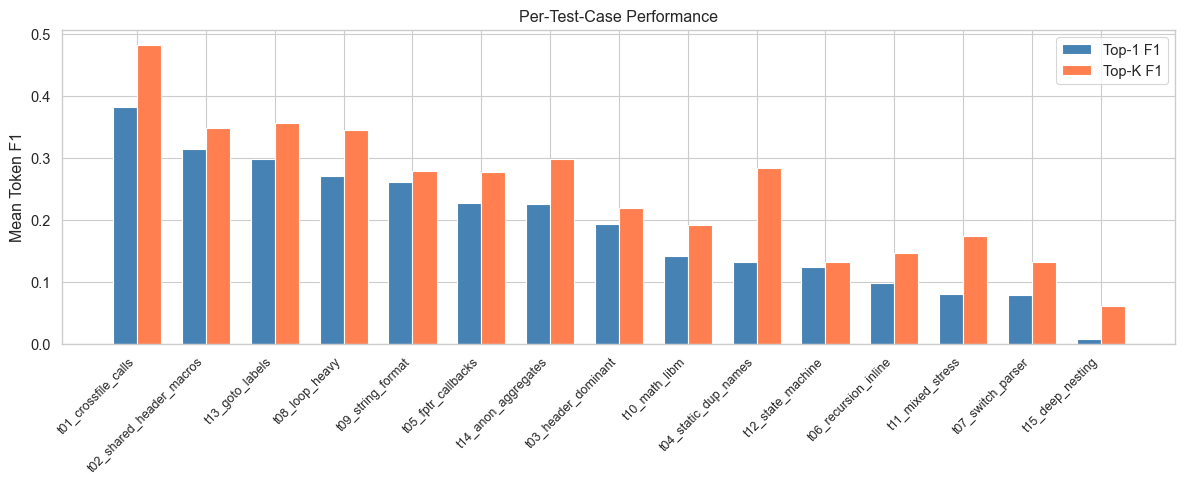

In [13]:
# Per test-case aggregate scoreboard
tc_agg = df.groupby('test_case').agg(
    n_rows=('token_f1', 'count'),
    n_functions=('stable_key', 'nunique'),
    mean_f1=('token_f1', 'mean'),
    median_f1=('token_f1', 'median'),
    exact_match_rate=('exact_match', 'mean'),
    mean_f1_topk=('token_f1_topk', 'mean'),
    mean_uplift=('topk_uplift', 'mean'),
    pct_f1_zero=('token_f1', lambda x: (x == 0).mean()),
).round(3).sort_values('mean_f1', ascending=False)

tc_agg['em_pct'] = (tc_agg['exact_match_rate'] * 100).round(1)
tc_agg['zero_pct'] = (tc_agg['pct_f1_zero'] * 100).round(1)

display(Markdown("### Per-Test-Case Scoreboard"))
display(tc_agg[['n_rows', 'n_functions', 'mean_f1', 'median_f1', 'em_pct',
                'mean_f1_topk', 'mean_uplift', 'zero_pct']]
        .style.background_gradient(subset=['mean_f1', 'mean_f1_topk'], cmap='RdYlGn')
        .background_gradient(subset=['zero_pct'], cmap='RdYlGn_r')
        .format({'mean_f1': '{:.3f}', 'median_f1': '{:.3f}', 'mean_f1_topk': '{:.3f}',
                 'mean_uplift': '{:+.3f}'}, na_rep='—'))

# Bar chart
fig, ax = plt.subplots(figsize=(12, 5))
x = range(len(tc_agg))
width = 0.35
ax.bar([i - width/2 for i in x], tc_agg['mean_f1'], width, label='Top-1 F1', color='steelblue')
ax.bar([i + width/2 for i in x], tc_agg['mean_f1_topk'], width, label='Top-K F1', color='coral')
ax.set_xticks(list(x))
ax.set_xticklabels(tc_agg.index, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Mean Token F1')
ax.set_title('Per-Test-Case Performance')
ax.legend()
plt.tight_layout()
plt.show()

## §8 — Token Overlap Analysis

Break down the token-level matching: which tokens from the ground truth did the model get right?
Helps understand if the model captures the *semantic core* of a name even when it's not an exact match.

In [14]:
# Token overlap analysis: split predictions and ground truth into tokens
# and show common / unique tokens

def tokenize(name):
    """Split snake_case name into token set."""
    if not isinstance(name, str) or not name:
        return set()
    return set(name.lower().split('_'))

token_rows = []
for _, row in df.iterrows():
    gt_tokens = tokenize(row['ground_truth'])
    pred_tokens = tokenize(row['predicted_name'])
    
    if not gt_tokens and not pred_tokens:
        continue
    
    common = gt_tokens & pred_tokens
    only_gt = gt_tokens - pred_tokens
    only_pred = pred_tokens - gt_tokens
    
    token_rows.append({
        'test_case': row['test_case'],
        'opt': row['opt'],
        'tier': row['tier'],
        'ground_truth': row['ground_truth'],
        'predicted_name': row['predicted_name'],
        'token_f1': row['token_f1'],
        'common_tokens': ', '.join(sorted(common)) if common else '—',
        'missed_tokens': ', '.join(sorted(only_gt)) if only_gt else '—',
        'extra_tokens': ', '.join(sorted(only_pred)) if only_pred else '—',
        'n_common': len(common),
        'n_missed': len(only_gt),
        'n_extra': len(only_pred),
    })

token_df = pd.DataFrame(token_rows)

# Show partial matches (F1 > 0 but < 1) — the most interesting for analysis
partial = token_df[(token_df['token_f1'] > 0) & (token_df['token_f1'] < 1)].copy()
partial = partial.sort_values('token_f1', ascending=False)

display(Markdown(f"### Partial Token Matches ({len(partial)} rows) — most informative cases"))
display(partial[['test_case', 'opt', 'tier', 'ground_truth', 'predicted_name',
                  'common_tokens', 'missed_tokens', 'extra_tokens', 'token_f1']]
        .head(40)
        .style.format({'token_f1': '{:.3f}'}, na_rep='—'))

# Aggregate: what are the most commonly missed GT tokens?
missed_counter = Counter()
extra_counter = Counter()
for _, row in token_df.iterrows():
    for t in row.get('missed_tokens', '').split(', '):
        if t and t != '—':
            missed_counter[t] += 1
    for t in row.get('extra_tokens', '').split(', '):
        if t and t != '—':
            extra_counter[t] += 1

print("\nMost frequently MISSED ground-truth tokens:")
for tok, cnt in missed_counter.most_common(15):
    print(f"  {tok:20s}  {cnt}x")

print("\nMost frequently ADDED (extra) tokens by model:")
for tok, cnt in extra_counter.most_common(15):
    print(f"  {tok:20s}  {cnt}x")

### Partial Token Matches (226 rows) — most informative cases

,test_case,opt,tier,ground_truth,predicted_name,common_tokens,missed_tokens,extra_tokens,token_f1
555,t01_crossfile_calls,O2,SILVER,string_to_upper,string_transform_to_upper,"string, to, upper",—,transform,0.857
4,t01_crossfile_calls,O0,GOLD,array_print,print_integer_array,"array, print",—,integer,0.800
40,t01_crossfile_calls,O0,GOLD,string_reverse,reverse_copy_string,"reverse, string",—,copy,0.800
45,t10_math_libm,O0,GOLD,geometric_mean,calculate_geometric_mean,"geometric, mean",—,calculate,0.800
276,t01_crossfile_calls,O1,GOLD,array_print,print_integer_array,"array, print",—,integer,0.800
297,t10_math_libm,O1,GOLD,geometric_mean,calculate_geometric_mean,"geometric, mean",—,calculate,0.800
202,t14_anon_aggregates,O1,GOLD,registry_process,process_registry_entries,"process, registry",—,entries,0.800
151,t01_crossfile_calls,O0,GOLD,array_sum,sum_array_elements,"array, sum",—,elements,0.800
163,t02_shared_header_macros,O0,GOLD,print_array,print_array_elements,"array, print",—,elements,0.800
124,t13_goto_labels,O0,GOLD,process_pipeline,process_pipeline_data,"pipeline, process",—,data,0.800



Most frequently MISSED ground-truth tokens:
  run                   63x
  main                  58x
  init                  36x
  deep                  30x
  plug                  30x
  mat                   30x
  state                 29x
  enter                 28x
  handle                18x
  engine                16x
  tests                 16x
  message               16x
  op                    16x
  b                     14x
  array                 14x

Most frequently ADDED (extra) tokens by model:
  calculate             71x
  value                 67x
  array                 60x
  data                  41x
  initialize            39x
  log                   39x
  and                   35x
  print                 32x
  pointer               31x
  sum                   27x
  elements              25x
  get                   22x
  message               21x
  count                 21x
  process               21x
